<div style="background:#f7f7f7; padding:20px; border-radius:12px; line-height:1.5;">

## Link Prediction

Link prediction is the problem of predicting the existence of a link between two nodes in a network.

<center><img src="GNN_bootcamp-main/images/link_prediction_problem.png" width="300"></center>

It has many applications such as: 
- **Friend recommendation in social networks:** The goal is to predict which pairs of users, who are not currently friends, are most likely to become friends based on the existing structure of the network and possibly other user-specific data.
- **Co-authorship prediction in citation networks:** Link prediction in co-authorship prediction within citation networks refers to the process of forecasting potential future collaborations between authors based on the existing structure and patterns of the network. In this context, a citation network is a graph where nodes represent authors (or papers), and edges represent co-authorship or citation relationships between them.
- **Movie recommendation in Netflix:** Link prediction in the context of movie recommendation on platforms like Netflix involves predicting the likelihood of a user forming a "link" (i.e., an interaction such as watching, rating, or liking) with a movie they have not yet interacted with. The goal is to recommend movies that the user is most likely to enjoy based on their past behavior and the behavior of other users with similar preferences.
- **Protein interaction prediction in biological networks:** Protein interaction prediction in biological networks, using link prediction, involves forecasting potential interactions between proteins within a biological network. This is crucial for understanding the molecular mechanisms underlying various biological processes and for identifying new targets for drug discovery.
- **Drug response prediction:** Link prediction in drug response prediction involves forecasting how different drugs will interact with various targets (such as proteins, genes, or cells) and how these interactions will result in a therapeutic response or adverse effect. The primary goal is to predict the effectiveness or toxicity of a drug on a specific biological target, which can help in personalized medicine, drug discovery, and understanding disease mechanisms.

</div>


<div style="background:#f7f7f7; padding:20px; border-radius:12px; line-height:1.5;">

### Traditional Link Prediction Methods

These methods can be categorized into three classes: 
- Heuristic methods 
- Latent-feature methods
- Content-based methods

The link prediction problem has been studied extensively, leading to the development of numerous techniques. 

---

We will first explore popular heuristics that utilize local and global neighborhood information. Can you think of a simple rule of thumb to predict whether two nodes should be connected?

- **Common neighbors (CN):** It is based on the intuition that "the more neighbors you have in common, the more likely you are to be connected". This heuristic simply counts the number of neighbors two nodes $ x $ and $ y $ have in common:
$$f_{CN}(x,y) = |\mathcal{N}(x) \cap \mathcal{N}(y)|$$

- **Jaccard coefficient:** measures the proportion of shared neighbors between two nodes. It builds on the idea of common neighbors but normalizes the count by the total number of neighbors. This method favors nodes with fewer neighbors over those with a high degree. This metric solves the problem where two nodes could have many common neighbors because they have lots of neighbors, not because they are strongly related.
$$f_{\text{Jaccard}}(x,y) = \frac{|\mathcal{N}(x) \cap \mathcal{N}(y)|}{|\mathcal{N}(x) \cup \mathcal{N}(y)|}$$

- **Preferential attachment (PA):** measures link likelihood using the product of node degrees. PA assumes that node $ x $ is more likely to connect to node $ y $ if $ y $ has a high degree. For instance, in citation networks, a new paper is more likely to cite papers that already have many citations.

- **Adamic-Adar (AA):** evaluates the strength of the link likelihood by considering the weight of common neighbors between two nodes. Each common neighbor $ z $ contributes to the score, but its influence is reduced based on its degree, with the contribution being inversely proportional to the logarithm of its degree:
$$f_{AA}(x,y) = \sum_{z \in \mathcal{N}(x) \cap \mathcal{N}(y)} \frac{1}{\log|\mathcal{N}(z)|}$$

Note: The Adamic-Adar (AA) heuristic is considered a second-order heuristic because it evaluates the likelihood of a link between two nodes by considering not just the direct properties of the nodes themselves but also the properties of their shared neighbors (i.e., second-order neighbors).

Three heuristics of CN, PA, and AA are illustrated in the following figure:
<center><img src="./GNN_bootcamp-main/images/link_prediction_heuristic.png" width="600"></center>
<center><small>Image from https://graph-neural-networks.github.io/static/file/chapter10.pdf</small></center>

---

One of the most popular latent feature methods is **matrix factorization**. This approach factorizes the observed adjacency matrix $ A $ of the network into the product of a low-rank latent embedding matrix $ Z \in \mathbb{R}^{n \times k} $ and its transpose (where $ n $ is the number of nodes and $ k $ is the dimension of hidden embeddings). Essentially, it approximates the edge between nodes $ i $ and $ j $ using their $ k $-dimensional latent embeddings, $ z_i $ and $ z_j $:
$$\hat{A}_{i,j} = z_i^T z_j$$
<center><img src="./GNN_bootcamp-main/images/matrix factorization concept.png" width="500"></center>
<center><small>Image from Labonne, Maxime. "Hands-On Graph Neural Networks Using Python: Practical techniques and architectures for building powerful graph and deep learning apps with PyTorch". Packt Publishing Ltd, 2023.</small></center>

Intuitively, if nodes $ i $ and $ j $ are similar, the dot product $ z_i^T z_j $ should be high, indicating a likely link between them. This dot product can be used to approximate each element (link) in the adjacency matrix.

The method then minimizes the mean squared error between the reconstructed adjacency matrix and the true adjacency matrix over the observed edges to learn these latent embeddings:
$$L = \sum_{(i,j) \in E} (A_{i,j} - \hat{A}_{i,j})^2$$

---

However, both heuristic methods and latent-feature methods rely solely on the network’s topology and do not incorporate node features when creating embeddings. Content-based methods use specific features associated with nodes to predict links, which is  common in recommender systems. For example, in citation networks, the words used in papers can serve as features. In social networks, a user’s profile details, like their age or interests, are used as features. However, content-based methods often perform worse than heuristic and latent-feature methods because they don’t use the connections between 

</div>

<div style="background:#f7f7f7; padding:20px; border-radius:12px; line-height:1.5;">

## Link prediction with GNN

In contrast to the traditional methods that either focus on graph structure or node features, GNN methods integrate both graph structure features and content features by learning them simultaneously in a unified framework, taking advantage of the powerful graph representation learning capabilities of GNNs.

There are two main paradigms for link prediction using GNNs: node-based and subgraph-based. **Node-based** methods aggregate the node representations learned by a GNN to form the link representation. In contrast, **subgraph-based** methods extract a local subgraph surrounding each potential link and use the representation of this subgraph, learned by a GNN, as the link representation.

---

### Node based GNN

The foundational node-based method for link prediction is the Graph AutoEncoder (GAE), introduced by Kipf and Welling in 2016. GAE is designed to learn low-dimensional node embeddings from graph data, which can then be used to predict the existence of links between nodes. Given a graph's adjacency matrix $A$ and node feature matrix $X$, GAE employs a Graph Convolutional Network (GCN) to compute a node representation $z_i$ for each node $i$:

\begin{equation*}
\hat{A}_{ij} = \sigma(z_i^T z_j), \quad \text{where } z_i = Z[i,:], \quad Z = \text{GCN}(X,A)
\end{equation*}

The prediction of a link between nodes $i$ and $j$ is based on the similarity score $s(z_i^T z_j)$, where the dot product between their embeddings $z_i$ and $z_j$ is used to estimate the likelihood of an edge between them. The specific prediction for the link is given by:

\begin{equation*}
\hat{A}_{ij} = \sigma(z_i^T z_j)
\end{equation*}

where:
- $Z$ is the matrix of node representations output by the GCN, with the $i$-th row $z_i = Z[i,:]$ representing the embedding for node $i$.
- $\hat{A}_{ij}$ is the predicted probability of a link between nodes $i$ and $j$.
- $\sigma$ is the sigmoid function, which ensures that the predicted probabilities lie between 0 and 1.

If no node feature matrix $X$ is provided, GAE can use a one-hot encoded identity matrix $I$ as input instead, treating each node's identity as its feature.

The GAE model is trained to minimize the cross-entropy loss between the reconstructed adjacency matrix $\hat{A}$ and the true adjacency matrix $A$. The loss function is defined as:

\begin{equation*}
L = \sum_{i \in V, j \in V} \left[ -A_{ij} \log \hat{A}_{ij} - (1 - A_{ij}) \log (1 - \hat{A}_{ij}) \right]
\end{equation*}

This loss function encourages the model to accurately reconstruct the adjacency matrix, effectively learning node embeddings that capture the underlying graph structure and are useful for predicting missing links.

<center><img src="./GNN_bootcamp-main/images/GAE.png" width=700></center>
<center><small>image from https://arxiv.org/pdf/1901.00596</small></center>

In practice, the loss for positive edges (where $A_{i,j} = 1$) is increased by a factor of $k$, which is the ratio of negative edges (where $A_{i,j} = 0$) to positive edges. This adjustment helps balance the impact of positive and negative edges on the overall loss. Without this, the loss could be overwhelmed by negative edges because real-world networks are often sparse, meaning there are many more negative edges than positive ones.

---

##### Does GAE just relearn the actual $A$?
It might seem like GAE (Graph AutoEncoder) is just trying to reconstruct the actual adjacency matrix $A$, but its real power lies in how it learns to generalize from the data. While GAE does try to reconstruct the adjacency matrix $A$, it's not just memorizing it. Instead, it's learning patterns and structures within the graph. By compressing the graph structure into a lower-dimensional space, the model can generalize to predict links that are not directly observed in the training data.

Hence, while GAE does aim to reconstruct the adjacency matrix $A$ during training, it's doing so by learning a compressed, latent representation of the graph. The model tries to capture the
underlying structure and patterns, not just memorize the existing connections. This learned representation can then be used to make predictions about new, unseen links that weren’t present in the original matrix. In essence, GAE generalizes from the observed data to infer the likelihood of connections between any pair of nodes, whether or not those connections were in the original graph.

---

### Subgraph-based GNN

Subgraph-based methods extract a local subgraph around each target link and learn a subgraph representation through a GNN for link prediction.

The pioneering work of subgraph-based methods is SEAL (Subgraph-based Embedding Attributed Learning). SEAL first extracts an enclosing subgraph for each target link to predict, and then applies a graph-level GNN (with pooling) to classify whether the subgraph corresponds to link existence.

The method defines the subgraph formed by the target nodes $(i, j)$ and their $k$-hop neighbors as the **enclosing subgraph**. This subgraph is used as the input for predicting the likelihood of a link between the two target nodes, rather than using the entire graph. Essentially, SEAL automatically <u>**learns** a local heuristic for link prediction</u> by focusing on the relevant local structure around the potential link.

The SEAL framework involves three key steps:

1. **Enclosing Subgraph Extraction**:
   - In this step, the algorithm identifies and extracts the subgraph that includes the target nodes and their $k$-hop neighbors. This subgraph captures the local structure around the target link.  
   The three different hops of a sample target node are illustrated in the following figure:  
   <center><img src="./GNN_bootcamp-main/images/hops.png" width="400"></center>

   - The training data consists of both real links (positive samples) and fake links (negative samples generated through negative sampling). By focusing on the enclosing subgraph, the model narrows its attention to the most relevant local information for predicting whether a link should exist.

2. **Node Label Construction**:
   - SEAL introduces an additional feature for each node within the subgraph through a technique called **Double Radius Node Labeling (DRNL)**. This assigns an integer label to each node based on its role and position relative to the target nodes.
   - The purpose of this labeling is to differentiate nodes based on their structural roles in the subgraph. For instance, the target nodes $i$ and $j$ are at the center of the subgraph and have a direct influence on the prediction, so they receive distinct labels. Nodes at different hop distances from $i$ and $j$ may also have varying importance in determining whether the link exists, so they are labeled accordingly.
   - Proper node labeling is crucial for the success of subgraph-based link prediction methods. By distinguishing nodes based on their roles, SEAL enhances its ability to learn effective link representations, making subgraph-based methods more powerful than node-based methods for link prediction.

   > **NOTE** \
   > DRNL (Double Radius Node Labeling) works like this:
   
      1. First, assign the label "1" to the two target nodes, $x$ and $y$.
      2. For any other node $i$ in the subgraph, its label is determined by how far it is from both $x$ and $y$. If the distance from $i$ to both $x$ and $y$ is 1, it gets label "2". If the distances are (1, 2) or (2, 1), it gets label "3", and so on.
      3. The further a node is from the two center nodes $x$ and $y$, the higher its label.

         There’s a formula to directly calculate the label for a node based on its distances to $x$ and $y$:

         \begin{equation*}
         l(i) = 1 + \text{min}(dx, dy) + \left(\frac{d}{2}\right)\left(\left(\frac{d}{2}\right) + (d \% 2) - 1\right)
         \end{equation*}

         Here, $dx$ and $dy$ are the distances from $i$ to $x$ and $y$, and $d$ is the sum of these distances. The formula uses basic arithmetic to assign labels systematically.

         For nodes that are too far away to have a meaningful distance to $x$ or $y$, they get a null label "0". After assigning DRNL labels, SEAL converts them into one-hot encoding vectors or feeds them into an embedding layer to generate their embeddings for use in the model.
         
         DRNL is illustrated in the following example:  
         <center><img src="./GNN_bootcamp-main/images/seal_node_labeling.png" width="400"></center>
         <center><small>image from https://graph-neural-networks.github
         .io/static/file/chapter10.pdf</small></center>

3. **GNN Training**:
   - In the final step, the node information matrices (which now include both the original features and the node labels) are fed into a Graph Neural Network (GNN). The GNN processes this information to output link likelihoods, essentially predicting how likely it is that a link exists between the target nodes.
   - By training the GNN on these subgraphs with labeled nodes, SEAL learns to identify patterns and structures that are indicative of link presence, allowing it to make accurate link predictions based on local subgraph information.

The steps in SEAL are illustrated in the following figure:

<center><img src="./GNN_bootcamp-main/images/SEAL_overall.png" width="800"></center>
<center><small>image from Labonne, Maxime. "Hands-On Graph Neural Networks Using Python: Practical techniques and architectures for building powerful graph and deep learning apps with PyTorch". Packt Publishing Ltd, 2023.</small></center>

</div>


Epoch 10, Loss: 1.7267
Epoch 20, Loss: 1.2078
Epoch 30, Loss: 1.1175
Epoch 40, Loss: 1.0381
Epoch 50, Loss: 0.9645
Epoch 60, Loss: 0.8825
Epoch 70, Loss: 0.8098
Epoch 80, Loss: 0.7421
Epoch 90, Loss: 0.6819
Epoch 100, Loss: 0.6319
Epoch 110, Loss: 0.5910
Epoch 120, Loss: 0.5576
Epoch 130, Loss: 0.5303
Epoch 140, Loss: 0.5050
Epoch 150, Loss: 0.4821
Epoch 160, Loss: 0.4613
Epoch 170, Loss: 0.4432
Epoch 180, Loss: 0.4260
Epoch 190, Loss: 0.4093
Epoch 200, Loss: 0.3926
Epoch 210, Loss: 0.3767
Epoch 220, Loss: 0.3618
Epoch 230, Loss: 0.3481
Epoch 240, Loss: 0.3349
Epoch 250, Loss: 0.3217
Epoch 260, Loss: 0.3082
Epoch 270, Loss: 0.2963
Epoch 280, Loss: 0.2858
Epoch 290, Loss: 0.2765
Epoch 300, Loss: 0.2676
Positive Edge Accuracy: 1.0000
Negative Edge Accuracy: 0.9507


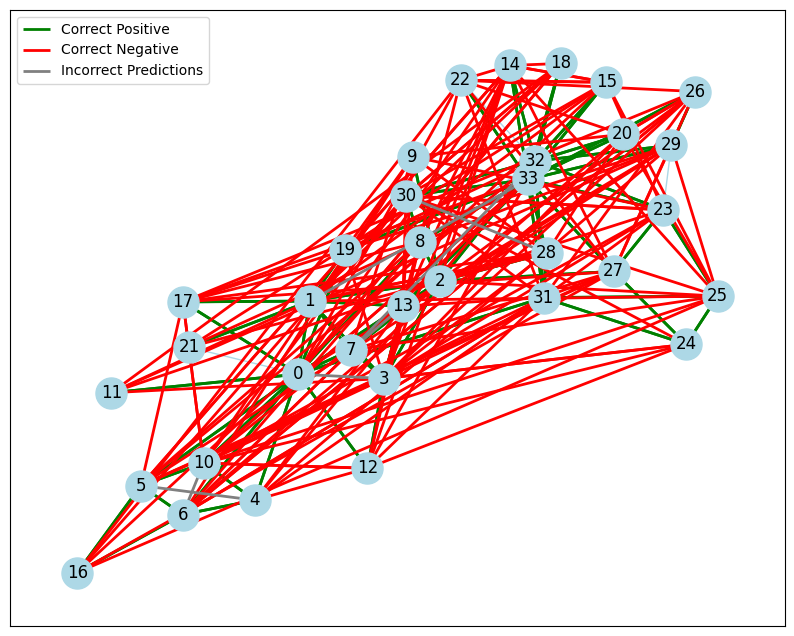

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import k_hop_subgraph, negative_sampling, to_networkx
import networkx as nx
from torch_geometric.nn import GCNConv, global_add_pool
from torch_geometric.data import Data, Batch
import matplotlib.pyplot as plt
from torch_geometric.transforms import RandomLinkSplit

# Load the Karate Club dataset
dataset = KarateClub()
data = dataset[0]

# Function to apply DRNL node labeling (keeps instructor's original logic)
def drnl_node_labeling(subgraph, src, dst):
    G = to_networkx(subgraph, to_undirected=True)
    src_dist = nx.single_source_shortest_path_length(G, src.item())
    dst_dist = nx.single_source_shortest_path_length(G, dst.item())
    labels = torch.zeros(subgraph.num_nodes, dtype=torch.long)

    for node in G.nodes:
        d_src = src_dist.get(node, 100)
        d_dst = dst_dist.get(node, 100)
        labels[node] = 1 + min(d_src, d_dst) + (d_src + d_dst)/2 * ((d_src + d_dst)/2 + ((d_src + d_dst)%2) - 1)
    labels[labels >= 3] = 0  # Cap labels to a max value of 2
    return labels

# Function to extract subgraph and apply DRNL (caches results)
def extract_subgraph_with_drnl(src, dst, edge_index, x, num_hops, cache):
    """
    same semantics as instructor: uses the passed edge_index to do k_hop_subgraph.
    Caches results in `cache` keyed by (src,dst,num_hops) where src/dst are ints.
    """
    key = (int(src), int(dst), int(num_hops))
    if key in cache:
        return cache[key]
    nodes, sub_edge_index, mapping, edge_mask = k_hop_subgraph([src, dst], num_hops, edge_index, relabel_nodes=True)
    sub_x = x[nodes]
    labels = drnl_node_labeling(Data(edge_index=sub_edge_index, x=sub_x), src=mapping[0], dst=mapping[1])
    cache[key] = (sub_x, sub_edge_index, labels, nodes)
    return cache[key]

# Define the GNN model with DRNL labels as input (unchanged)
class GNNWithLabels(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_node_labels):
        super(GNNWithLabels, self).__init__()
        self.conv1 = GCNConv(in_channels + num_node_labels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, node_labels, batch):
        x = torch.cat([x, node_labels], dim=-1)
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = global_add_pool(x, batch)
        return torch.sigmoid(x)

# Train-test split for edges (keeps instructor's transform)
data2 = data.clone()
transform = RandomLinkSplit(is_undirected=True, num_val=0, num_test=0.1)
train_data, val_data, test_data = transform(data)

train_pos_edge_index = train_data.edge_index
test_pos_edge_index = test_data.edge_index

train_neg_edge_index = negative_sampling(
    edge_index=train_data.edge_index,
    num_nodes=train_data.num_nodes,
    num_neg_samples=train_data.edge_index.size(1)
)

test_neg_edge_index = negative_sampling(
    edge_index=test_data.edge_index,
    num_nodes=test_data.num_nodes,
    num_neg_samples=test_data.edge_index.size(1)
)

# Convert edge lists to tuples for hashing/membership checks
train_pos_list = [tuple(e) for e in train_pos_edge_index.t().tolist()]
train_neg_list = [tuple(e) for e in train_neg_edge_index.t().tolist()]
test_pos_list = [tuple(e) for e in test_pos_edge_index.t().tolist()]
test_neg_list = [tuple(e) for e in test_neg_edge_index.t().tolist()]

# Training function (keeps the instructor's outputs/formatting; optimized internally)
def train(model, data, pos_edge_index, neg_edge_index, num_hops, optimizer, device, num_node_labels, cache, batch_size_edges=32):
    model.train()
    optimizer.zero_grad()

    total_loss = 0.0
    # Build combined tuple-edge list in identical order as original (pos then neg)
    all_edges = train_pos_list + train_neg_list
    pos_set = set(train_pos_list)  # use tuples so set() is valid

    # Process edges in chunks (batched forward) but keep ordering & semantics
    for i in range(0, len(all_edges), batch_size_edges):
        chunk = all_edges[i:i+batch_size_edges]
        data_list = []
        targets = []
        for edge in chunk:
            src, dst = edge
            sub_x, sub_edge_index, labels, nodes = extract_subgraph_with_drnl(
                src, dst, edge_index=pos_edge_index, x=data.x, num_hops=num_hops, cache=cache
            )
            one_hot_labels = F.one_hot(labels, num_classes=num_node_labels).float()
            sub = Data(x=sub_x, edge_index=sub_edge_index)
            sub.node_label = one_hot_labels
            data_list.append(sub)
            targets.append(1.0 if edge in pos_set else 0.0)

        big_batch = Batch.from_data_list(data_list)
        node_label_tensor = torch.cat([d.node_label for d in data_list], dim=0)

        x_dev = big_batch.x.to(device, non_blocking=True)
        edge_index_dev = big_batch.edge_index.to(device, non_blocking=True)
        node_label_dev = node_label_tensor.to(device, non_blocking=True)
        batch_index = big_batch.batch.to(device, non_blocking=True)

        out = model(x_dev, edge_index_dev, node_label_dev, batch_index)
        targets_tensor = torch.tensor(targets, dtype=torch.float32, device=device).unsqueeze(1)

        loss = F.binary_cross_entropy(out, targets_tensor)
        loss.backward()
        total_loss += loss.item() * len(chunk)

    optimizer.step()
    return total_loss / len(pos_edge_index[1])

# Testing function (keeps prints identical; processes edges in batches)
def test(model, data, pos_edge_index, neg_edge_index, num_hops, device, num_node_labels, cache, threshold=0.5, batch_size_edges=32):
    model.eval()

    # Use tuple lists and set for membership checks
    all_edges = test_pos_list + test_neg_list
    pos_set = set(test_pos_list)

    correct_pos, correct_neg = 0, 0
    total_pos, total_neg = len(pos_edge_index[1]), len(neg_edge_index[1])
    predictions = []

    with torch.no_grad():
        for i in range(0, len(all_edges), batch_size_edges):
            chunk = all_edges[i:i+batch_size_edges]
            data_list = []
            edges_in_chunk = []
            for edge in chunk:
                src, dst = edge
                sub_x, sub_edge_index, labels, nodes = extract_subgraph_with_drnl(
                    src, dst, edge_index=pos_edge_index, x=data.x, num_hops=num_hops, cache=cache
                )
                one_hot_labels = F.one_hot(labels, num_classes=num_node_labels).float()
                sub = Data(x=sub_x, edge_index=sub_edge_index)
                sub.node_label = one_hot_labels
                data_list.append(sub)
                edges_in_chunk.append(edge)

            big_batch = Batch.from_data_list(data_list)
            node_label_tensor = torch.cat([d.node_label for d in data_list], dim=0)

            x_dev = big_batch.x.to(device, non_blocking=True)
            edge_index_dev = big_batch.edge_index.to(device, non_blocking=True)
            node_label_dev = node_label_tensor.to(device, non_blocking=True)
            batch_index = big_batch.batch.to(device, non_blocking=True)

            out = model(x_dev, edge_index_dev, node_label_dev, batch_index)
            out_cpu = out.squeeze(1).cpu().tolist()

            for edge, prediction in zip(edges_in_chunk, out_cpu):
                predictions.append(prediction)
                if edge in pos_set:
                    if prediction >= threshold:
                        correct_pos += 1
                else:
                    if prediction < threshold:
                        correct_neg += 1

    pos_acc = correct_pos / total_pos
    neg_acc = correct_neg / total_neg

    print(f'Positive Edge Accuracy: {pos_acc:.4f}')
    print(f'Negative Edge Accuracy: {neg_acc:.4f}')

    return pos_acc, neg_acc, predictions

# Visualization function (unchanged except uses CPU objects for networkx)
def visualize_predictions(predictions, pos_edge_index, neg_edge_index, threshold=0.5):
    G = to_networkx(Data(edge_index=data2.edge_index, x=data2.x), to_undirected=True)

    pos_correct_edges = []
    neg_correct_edges = []
    incorrect_edges = []

    combined = test_pos_list + test_neg_list
    for index, edge in enumerate(combined):
        src, dst = edge
        if edge in test_pos_list:
            if predictions[index] >= threshold:
                pos_correct_edges.append((src, dst))
            else:
                incorrect_edges.append((src, dst))
        else:
            if predictions[index] < threshold:
                neg_correct_edges.append((src, dst))
            else:
                incorrect_edges.append((src, dst))

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
    nx.draw_networkx_edges(G, pos, edge_color='lightblue')
    nx.draw_networkx_edges(G, pos, edgelist=pos_correct_edges, edge_color='green', width=2, label='Correct Positive')
    nx.draw_networkx_edges(G, pos, edgelist=neg_correct_edges, edge_color='red', width=2, label='Correct Negative')
    nx.draw_networkx_edges(G, pos, edgelist=incorrect_edges, edge_color='gray', width=2, label='Incorrect Predictions')

    nx.draw_networkx_labels(G, pos)
    plt.legend()
    plt.show()

# Initialize model, optimizer, and hyperparameters (keeps strings/formatting same)
num_node_labels = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNWithLabels(in_channels=data.num_node_features, hidden_channels=8, out_channels=1, num_node_labels=num_node_labels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Cache for subgraphs + labels
subgraph_cache = {}

# Train the model on the training edges
for epoch in range(1, 301):
    loss = train(model, data, train_pos_edge_index, train_neg_edge_index, num_hops=2, optimizer=optimizer, device=device, num_node_labels=num_node_labels, cache=subgraph_cache, batch_size_edges=32)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Test the model on unseen edges (test set)
pos_acc, neg_acc, predictions = test(model, data, test_pos_edge_index, test_neg_edge_index, num_hops=2, device=device, num_node_labels=num_node_labels, cache=subgraph_cache, threshold=0.5, batch_size_edges=32)

# Visualize the prediction results (exact same visualization)
visualize_predictions(predictions, test_pos_edge_index, test_neg_edge_index)


<div style="background:#f7f7f7; padding:20px; border-radius:12px; line-height:1.5;">

## Explaining Graph Neural Networks

Explainability in AI refers to the ability of AI models, especially complex ones like deep learning models, to provide **understandable**, **interpretable**, and **transparent** explanations for their decisions and predictions. In other words, it aims to make the "black box" of AI more transparent, so that humans can understand why an AI system made a particular choice.

In GNNs, information propagates across the graph, meaning that decisions are often influenced by distant nodes or multi-hop neighbors. *Explaining which nodes and paths influenced a specific prediction can be complex.* Explaining GNNs is a new field that takes a lot of ideas from other explainable AI (XAI) methods. Different explanation methods exist to understand how and why a GNN made a specific prediction. These techniques will help us see which nodes, edges, or features in the graph were most important in influencing the decision, making it easier to interpret the model's reasoning.

Key aspects we try to explain in GNN include:

- **Feature Importance**: Which node features (attributes) are most important in determining the node’s prediction? For instance, if we are predicting the role of a user in a social network, what aspects of the user (e.g., number of connections, user behavior) contributed most to the prediction?

- **Neighborhood Influence**: Which neighboring nodes and their features played a significant role in the prediction? GNNs aggregate information from nearby nodes, so understanding how the local structure and neighbors influenced the target node is crucial.

- **Why was this edge predicted?**: What aspects of the two connected nodes, their features, and their relationships (e.g., common neighbors or structural similarity) made the GNN predict that an edge should exist between them? For example, in a social network, why the GNN predicted a friendship link between two users? The explanation might reveal common friends, shared interests, or similar activity patterns as the reasons behind the prediction.

</div>


<div style="background:#f7f7f7; padding:20px; border-radius:12px; line-height:1.5;">

### GNNExplainer

GNNExplainer is a technique that helps understand the decisions made by a Graph Neural Network (GNN). It aims to provide clear explanations for the predictions of GNNs by identifying which parts of the graph (nodes, edges, and their features) are most important for a particular prediction.

Introduced in 2019, GNNExplainer is a method for explaining predictions made by another Graph Neural Network (which is already trained). Graph data requires us to identify which nodes and features are most influential. GNNExplainer provides explanations by highlighting a smaller subgraph and specifying which node features were key to the prediction. The figure below shows an example of what GNNExplainer's explanation looks like for a specific node:  
<center><img src="./GNN_bootcamp-main/images/explainer_illustration.png" width=400></center>
<center><small>image from Labonne, Maxime. "Hands-On Graph Neural Networks Using Python: Practical techniques and architectures for building powerful graph and deep learning apps with PyTorch". Packt Publishing Ltd, 2023.</small></center>

---

**Problem setup**: 

- Let Graph $G$ be a graph with nodes $V$ and edges $E$. Nodes are associated with $d$-dimensional features. The feature matrix $X$ is defined as $X = \{x_1, \ldots, x_n\}$, where $x_i \in \mathbb{R}^d$ is the feature vector for node $i$. Here, $n$ is the number of nodes in the graph, and $d$ is the dimensionality of the node features.

- We are specifically interested in explaining the predictions made for a **node classification** task. In this task, each node $v \in V$ is mapped to a class label $f(v) \in \{1, \ldots, C\}$, where $C$ is the number of possible classes.

- Let $\Phi$ be a Graph Neural Network model optimized on the training set of nodes. The model $\Phi$ approximates the label function $f$ for predicting the class of new nodes.

GNNExplainer aims to provide an explanation for the predictions made by the trained GNN model $\Phi$. Specifically, it tries to identify **a subgraph $G_S$** and a **subset of node features $X_S$** that are most influential in determining the model's prediction for a particular node $v$.

> **Key Idea: Importance Determination:**  \
> If removing an edge or feature significantly changes the prediction, that edge or feature is considered important. If the prediction remains the same, the edge or feature is less important.

GNNExplainer measures the importance of edges and features by evaluating the *mutual information* between the prediction and the masked subgraph:

\begin{equation*}
\max_{G_S,X_S} MI = I(Y_G;Y_{G_S})=H(Y|G,X)-H(Y|G_S,X_S)
\end{equation*}

where $Y_G$ is the label matrix predicted by the original trained model $\Phi$ and $Y_{G_S}$ is the label matrix predicted on the masked graph and features $(G_S,X_S)$. Note that the entropy term $H(Y|G,X)$ is constant because $\Phi$ is fixed for a trained GNN. As a result, the optimization problem is simplified as:

\begin{equation*}
\min_{G_S,X_S} H(Y|G_S,X_S) = \sum_{y} P_\Phi(y|G_S,X_S) \log(P_\Phi(y|G_S,X_S)) = E_{Y|G_S,X_S} [\log(P_\Phi(y|G_S,X_S))]
\end{equation*}

Direct optimization of GNNExplainer's objective is not tractable as the graph $G$ has exponentially many subgraphs $G_S$ that are candidate explanations. Instead of manually selecting edges, GNNExplainer learns the edge mask by using a differentiable process. Let's denote the edge mask as $M \in \mathbb{R}^{n \times n}$. Each entry in $M$ represents how much importance or influence the corresponding edge has on the GNN's prediction.

The mask is initialized randomly and is optimized during training. The mask values are passed through a sigmoid function to constrain them between 0 and 1. This makes the mask differentiable and ensures that GNNExplainer can learn it through gradient-based optimization. The computationally efficient version of GNNExplainer's objective, which could be optimized using gradient descent, is as follows:

\begin{equation*}
\min_{M} - \sum_{c=1}
^C 1[y=c] \log\left(P_\Phi(Y=y|G=A \odot \sigma(M),X)\right) 
\end{equation*}

where $1[\cdot]$ is an indicator function that equals 1 if the condition is satisfied and 0 otherwise.

To obtain a compact explanation, we can impose a constraint on $G_S$ size as: $|G_S| \leq K$, so that $G_S$ has at most $K$ nodes.

The feature mask determines which node features are the most influential in the GNN's decision-making process. The feature mask $F$ is also learned in a differentiable manner during training. Each value in $F$ corresponds to how important a particular feature dimension is for the model's decision. The masking here is a little different from masking the edges:

- If a particular feature is not important, perturbing the value does not change the model's decision. 
- If the feature is important, then it should be kept as it was.

In particular, to backpropagate through a $d$-dimensional masked feature, we reparameterize $X$ as: 

\begin{equation*} 
X = Z + (X_S - Z) \odot F
\end{equation*}

where $Z$ is a $d$-dimensional random variable and $X_S = \{x_j | v_j \in G_S\}$. 

When an element in $F$ is close to zero, the corresponding entry in $X_S$ is deemed unimportant, and the entry in $X$ is replaced by a perturbation that is expected not to influence the prediction. Conversely, when an element in $F$ is close to one, the corresponding entry in $X_S$ is retained, as it is considered important.

</div>



### Simple Toy Example in Torch Geometric

This code creates a small graph with node features and labels (5 nodes, 2 features per node and binary labels), defines a simple GCN model, and trains it to classify nodes. After training, GNNExplainer is used to interpret the model's decisions by identifying important nodes, edges, and features that influenced the classification.

The first figure displays the original graph, the second figure highlights the most influential nodes and edges, and the third figure illustrates the overall importance of each feature.

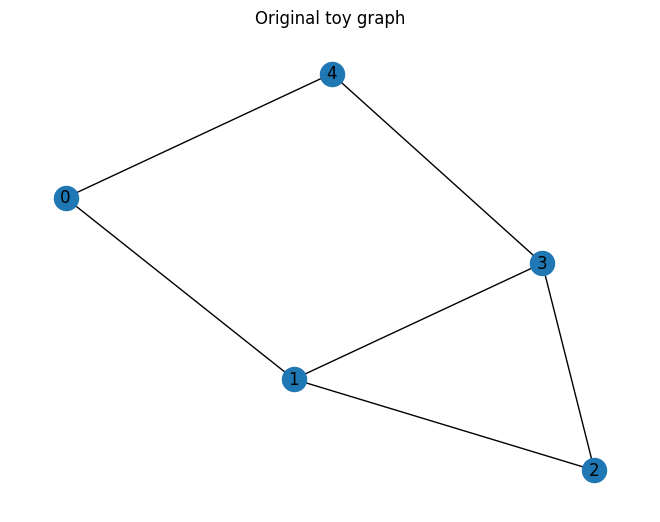

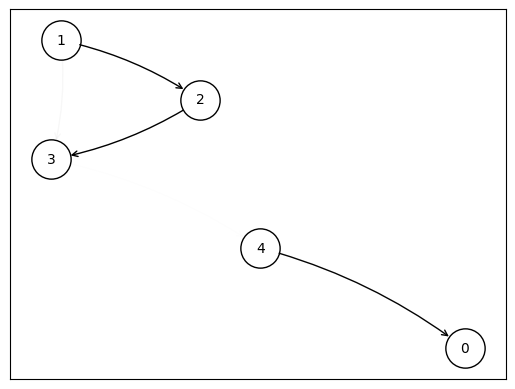

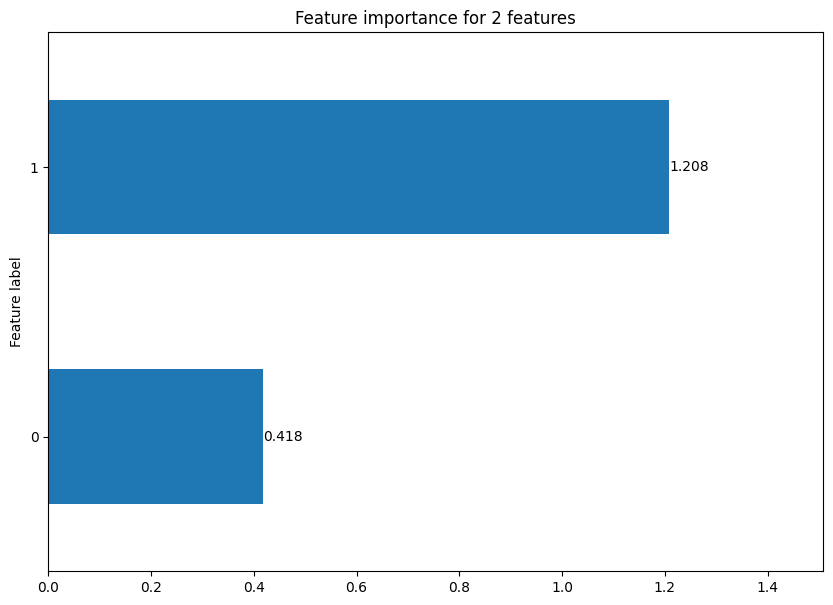

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# 1. Create a Small Synthetic Graph
edge_index = torch.tensor([
    [0, 1, 2, 3, 4, 1],
    [1, 2, 3, 4, 0, 3]
], dtype=torch.long)

# 5 nodes, 2 features per node
x = torch.tensor([
    [1, 0],
    [0, 1],
    [1, 1],
    [0, 0],
    [1, 0]
], dtype=torch.float)

# Labels for node classification
y = torch.tensor([0, 1, 0, 1, 0], dtype=torch.long)

# Create the data object
data = Data(x=x, edge_index=edge_index, y=y)

G = nx.Graph()
G.add_nodes_from(range(5))
G.add_edges_from(list(map(lambda x: (x[0].item(),x[1].item()),edge_index.T)))
nx.draw(G,with_labels=True)
plt.title("Original toy graph")
plt.show()
# 2. Define a Simple GNN Model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(2, 4)
        self.conv2 = GCNConv(4, 2)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN()

# 3. Train the GNN on the Graph
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data.x,data.edge_index)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()

# 4. Initialize GNNExplainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)
fig = plt.figure()
explanation = explainer(data.x, data.edge_index)
explanation.visualize_graph()
explanation.visualize_feature_importance()



<div style="background:#f7f7f7; padding:20px; border-radius:12px; line-height:1.5;">

## Using GNNExplainer for Interpreting Models in Real-World

This code is designed to explain the decision-making process of a GCN on the **Twitch social network dataset** using the **GNNExplainer**.

The Twitch dataset provides insights into streamers, their streaming behaviors, and whether they use explicit language during streams. This data is structured as a graph, where each **node** represents a streamer, and the **edges** indicate friendships or connections between streamers on the platform. The node features are based on the games played and liked, location, and streaming habits of streamers. The features are embeddings, which cannot be interpreted directly.  
<center><img src="./GNN_bootcamp-main/images/twitch.png" width=600></center>
<center><small>Image from https://www.youtube.com/watch?v=aFnlmzFh4iQ </small></center>

An example of a node classification task on the graph is determining whether a streamer uses explicit language. This is a binary classification problem, where each streamer is labeled as either using explicit language or not. The GNNExplainer can be used to identify which nodes contributed to predicting that a streamer uses explicit language based on their friendships.

We can use the GCN model to classify nodes into different categories. Once the model is trained (or in this case, assumed to be pre-trained), we use **GNNExplainer** to analyze the model's prediction for a specific node. The explainer tries to identify which edges (friendships) in the graph were most influential in the model's decision.

To do this, the code generates a subgraph consisting of all nodes and edges within a 3-hop radius of the target node. It uses this subgraph to visualize the relationships and highlight the most important edges. The importance of these edges is determined by the **GNNExplainer**, which assigns an importance score (or mask) to each edge, showing how much that edge contributed to the final prediction.

In the final visualization, the graph is displayed with different colors to show:
- The target node (node with index 0) for which we want to interpret the decision (in a red circle).
- The overall graph structure (in green).
- The subgraph (local neighborhood) around the target node (in blue).
- The key edges identified by GNNExplainer as crucial for the node's prediction (in red).

This approach allows us to interpret and understand how the model uses graph structure to make predictions, providing insights into the decision-making process of the GCN model.

</div>


Error loading Twitch dataset: Failed to interpret file './data/twitch\\raw/EN.npz' as a pickle
Creating a dummy dataset for testing...
Using device: cuda
Explaining node 0 with target class 1
Explanation generated successfully
Highlighted 27 important edges (threshold: 0.0000)


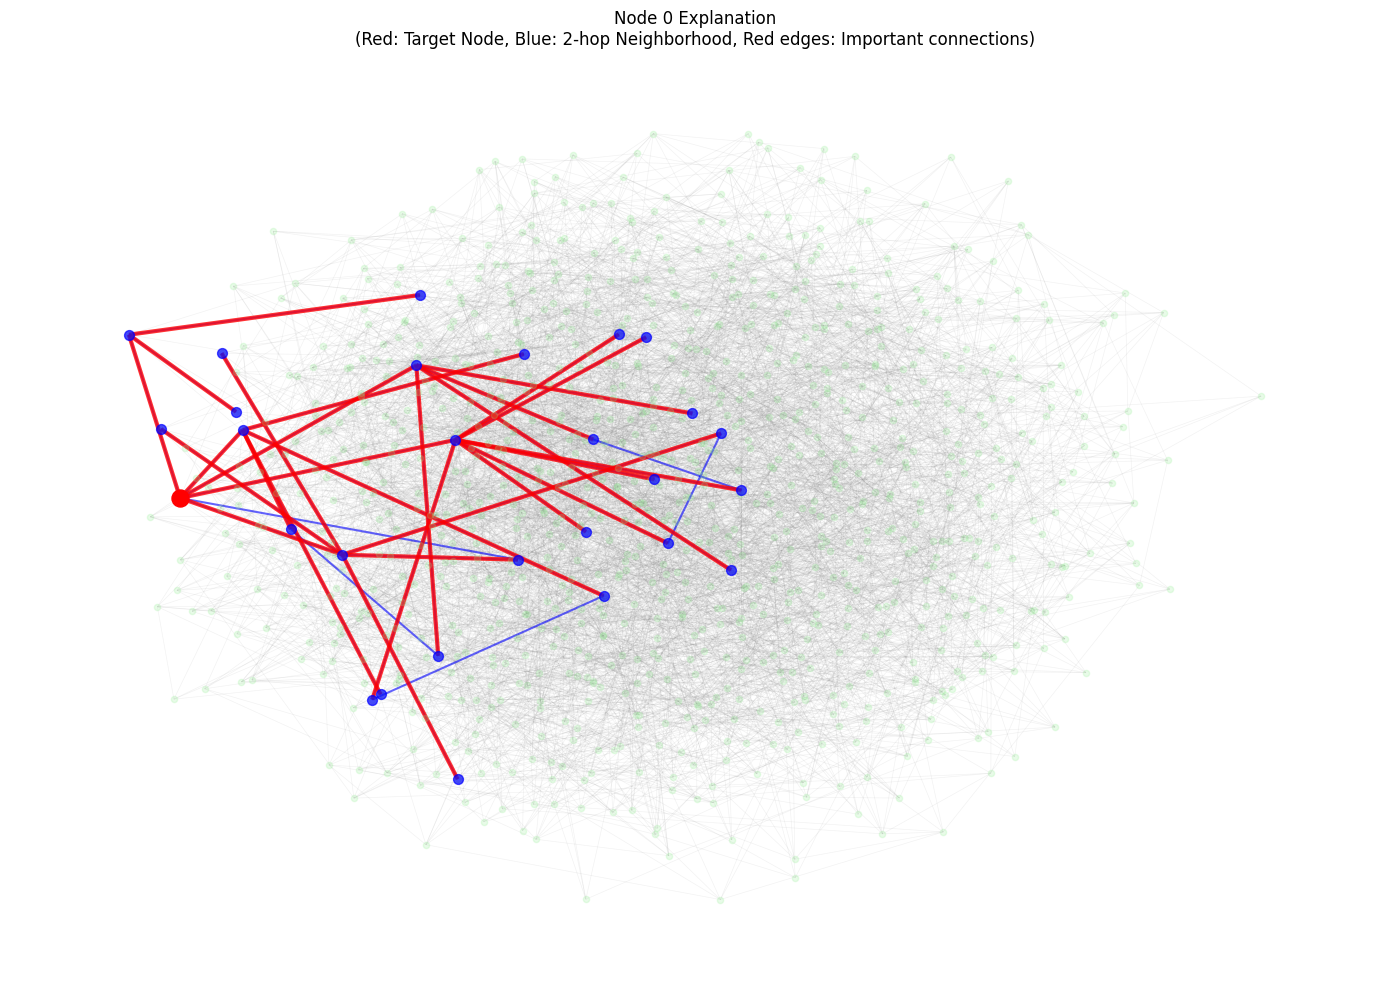


Graph statistics:
  - Number of nodes: 1000
  - Number of edges: 4996
  - Number of features: 128
  - Number of classes: 2
  - Target node class: 1
Edge mask statistics:
  - Min: 0.0000
  - Max: 0.8013
  - Mean: 0.0031
  - Std: 0.0458
Subgraph statistics:
  - Number of nodes in 2-hop subgraph: 28
  - Number of edges in 2-hop subgraph: 32


In [6]:
import torch
import torch_geometric.transforms as T
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.nn import GCN
from torch_geometric.utils import k_hop_subgraph
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.data import Data
import os

# 1. Manually load the Twitch dataset from your local files
def load_twitch_manual(data_path):
    """Manually load Twitch dataset from npz file"""
    try:
        # Load with allow_pickle=True
        twitch_data = np.load(os.path.join(data_path, 'raw/EN.npz'), allow_pickle=True)
        
        print("Available keys in npz file:", list(twitch_data.keys()))
        
        # The Twitch dataset typically has these keys, but let's check what's available
        if 'features' in twitch_data:
            features = twitch_data['features']
        elif 'x' in twitch_data:
            features = twitch_data['x']
        else:
            raise KeyError("Could not find features in the npz file")
            
        if 'edges' in twitch_data:
            edges = twitch_data['edges']
        elif 'edge_index' in twitch_data:
            edges = twitch_data['edge_index']
        else:
            raise KeyError("Could not find edges in the npz file")
            
        if 'label' in twitch_data:
            labels = twitch_data['label']
        elif 'y' in twitch_data:
            labels = twitch_data['y']
        else:
            raise KeyError("Could not find labels in the npz file")
        
        # Create PyG Data object
        data = Data(
            x=torch.tensor(features, dtype=torch.float),
            edge_index=torch.tensor(edges, dtype=torch.long).t().contiguous(),
            y=torch.tensor(labels, dtype=torch.long)
        )
        
        print(f"Successfully loaded Twitch dataset:")
        print(f"  - Nodes: {data.num_nodes}")
        print(f"  - Features: {data.num_node_features}")
        print(f"  - Edges: {data.num_edges}")
        print(f"  - Classes: {len(torch.unique(data.y))}")
        
        return data
        
    except Exception as e:
        print(f"Error loading Twitch dataset: {e}")
        # Create a dummy dataset for testing
        print("Creating a dummy dataset for testing...")
        return create_dummy_dataset()

def create_dummy_dataset():
    """Create a dummy dataset if Twitch loading fails"""
    num_nodes = 1000
    num_features = 128
    num_classes = 2
    
    # Create random features
    x = torch.randn(num_nodes, num_features)
    
    # Create random edges (sparse graph)
    edge_index = []
    for i in range(num_nodes):
        # Connect each node to 5 random other nodes
        neighbors = torch.randperm(num_nodes)[:5]
        for j in neighbors:
            if i != j:
                edge_index.append([i, j])
    
    edge_index = torch.tensor(edge_index).t().contiguous()
    
    # Create random labels
    y = torch.randint(0, num_classes, (num_nodes,))
    
    return Data(x=x, edge_index=edge_index, y=y)

# Load the dataset
dataset_path = './data/twitch'
data = load_twitch_manual(dataset_path)

# Create a dummy dataset object for compatibility
class DummyDataset:
    def __init__(self, num_classes):
        self.num_classes = num_classes

dataset = DummyDataset(num_classes=len(torch.unique(data.y)))

# 2. Create the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
data = data.to(device)

model = GCN(data.num_node_features, hidden_channels=64, num_layers=2,
            out_channels=dataset.num_classes).to(device)
model.eval()

# 3. Initialize GNNExplainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100),  # Reduced for faster execution
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

# 4. Choose a node to explain (make sure it's within range)
node_idx = min(0, data.num_nodes - 1)
target = data.y[node_idx]

print(f"Explaining node {node_idx} with target class {target.item()}")

# 5. Explain the node
try:
    explanation = explainer(x=data.x, edge_index=data.edge_index, index=node_idx)
    node_feat_mask = explanation.node_mask
    edge_mask = explanation.edge_mask
    print("Explanation generated successfully")
except Exception as e:
    print(f"Error during explanation: {e}")
    # Create dummy masks for visualization
    node_feat_mask = None
    edge_mask = torch.ones(data.edge_index.size(1), device=device)

# 6. Get the 2-hop subgraph around the node
subset, _, _, hard_edge_mask = k_hop_subgraph(
    node_idx, num_hops=2, edge_index=data.edge_index, relabel_nodes=False
)

# 7. Convert to numpy for visualization
edge_mask_np = edge_mask.cpu().detach().numpy() if edge_mask is not None else np.ones(data.edge_index.size(1))
hard_edge_mask_np = hard_edge_mask.cpu().numpy()

# 8. Create NetworkX graph for visualization
G = nx.Graph()
edge_index_cpu = data.edge_index.cpu().numpy()
G.add_edges_from(edge_index_cpu.T.tolist())

# For large graphs, use only the subgraph for better visualization
if len(G.nodes()) > 1000:
    G = nx.Graph()
    subgraph_edges = data.edge_index[:, hard_edge_mask].cpu().numpy().T.tolist()
    G.add_edges_from(subgraph_edges)
    print("Using subgraph for visualization (graph too large)")

pos = nx.spring_layout(G, seed=42, k=1/np.sqrt(len(G.nodes())), iterations=50)

plt.figure(figsize=(14, 10))

# Draw all edges with low opacity
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='grey', width=0.5)

# Draw all nodes
nx.draw_networkx_nodes(G, pos, node_size=20, alpha=0.2, node_color='lightgreen')

# Highlight nodes in the subgraph
nx.draw_networkx_nodes(G, pos, nodelist=subset.cpu().tolist(), 
                      node_size=50, node_color='blue', alpha=0.7)

# Highlight the target node
nx.draw_networkx_nodes(G, pos, nodelist=[node_idx], 
                      node_size=150, node_color='red', alpha=1.0)

# Draw edges in the subgraph
subgraph_edges = data.edge_index[:, hard_edge_mask].cpu().numpy().T.tolist()
nx.draw_networkx_edges(G, pos, edgelist=subgraph_edges, 
                      edge_color='blue', width=1.5, alpha=0.6)

# Draw edges highlighted by GNNExplainer with threshold
if edge_mask is not None:
    threshold = np.percentile(edge_mask_np, 75)  # Top 25% important edges
    important_edges_mask = edge_mask_np > threshold
    highlighted_edges = data.edge_index[:, important_edges_mask].t().cpu().numpy()

    if len(highlighted_edges) > 0:
        nx.draw_networkx_edges(G, pos, edgelist=highlighted_edges.tolist(), 
                              edge_color='red', width=3.0, alpha=0.8)
        print(f"Highlighted {len(highlighted_edges)} important edges (threshold: {threshold:.4f})")

plt.title(f'Node {node_idx} Explanation\n(Red: Target Node, Blue: 2-hop Neighborhood, Red edges: Important connections)')
plt.axis('off')
plt.tight_layout()
plt.show()

# Print statistics
print(f"\nGraph statistics:")
print(f"  - Number of nodes: {data.num_nodes}")
print(f"  - Number of edges: {data.num_edges}")
print(f"  - Number of features: {data.num_node_features}")
print(f"  - Number of classes: {dataset.num_classes}")
print(f"  - Target node class: {target.item()}")
if edge_mask is not None:
    print(f"Edge mask statistics:")
    print(f"  - Min: {edge_mask_np.min():.4f}")
    print(f"  - Max: {edge_mask_np.max():.4f}")
    print(f"  - Mean: {edge_mask_np.mean():.4f}")
    print(f"  - Std: {edge_mask_np.std():.4f}")
print(f"Subgraph statistics:")
print(f"  - Number of nodes in 2-hop subgraph: {len(subset)}")
print(f"  - Number of edges in 2-hop subgraph: {hard_edge_mask.sum().item()}")

In [7]:
import subprocess

result = subprocess.check_output(["nvidia-smi", "--query-gpu=name", "--format=csv,noheader"])
print(result.decode().strip())


NVIDIA GeForce GTX 1050
